In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from keras import layers, metrics, optimizers, losses, activations
import matplotlib.pyplot as plt
from IPython.display import clear_output

2023-05-29 23:42:36.715125: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-29 23:42:36.737885: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-29 23:42:37.113549: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
(train, valid, test), info = tfds.load(
    "oxford_iiit_pet", with_info=True, split=["train", "test[:30%]", "test[30%:]"]
)

2023-05-29 23:42:37.732623: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-29 23:42:37.750153: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-29 23:42:37.750236: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
def load_and_normalize_img(image, mask):
    image = tf.image.resize(image, (128, 128))
    mask = tf.image.resize(
        mask, (128, 128), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    return tf.cast(image, tf.float32) / 255.0, tf.subtract(mask, [1])

In [4]:
ds_train = train.map(
    lambda ds: (
        load_and_normalize_img(ds["image"], ds["segmentation_mask"]),
        ds["file_name"],
        ds["label"],
        ds["species"],
    ),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
)

In [22]:
ds_valid = valid.map(
    lambda ds: (
        load_and_normalize_img(ds["image"], ds["segmentation_mask"]),
        ds["file_name"],
        ds["label"],
        ds["species"],
    ),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
)

In [5]:
ds_test = test.map(
    lambda ds: (
        load_and_normalize_img(ds["image"], ds["segmentation_mask"]),
        ds["file_name"],
        ds["label"],
        ds["species"],
    ),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
)

In [6]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        self.augment_inputs = tf.keras.layers.RandomFlip("horizontal", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip("horizontal", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

In [23]:
train_batches = (
    ds_train.map(lambda x, y, z, w: (x[0], x[1]))
    .cache()
    .shuffle(1000)
    .batch(32)
    .repeat()
    .map(Augment(), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

valid_batches = (
    ds_valid
    .map(lambda x, y, z, w: (x[0], x[1]))
    .batch(32)
    .prefetch(tf.data.experimental.AUTOTUNE)
    )

test_batches = (
    ds_test
    .map(lambda x, y, z, w: (x[0], x[1]))
    .batch(32)
    .prefetch(tf.data.experimental.AUTOTUNE)
    )



In [8]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()

2023-05-29 23:42:41.787705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [4]
	 [[{{node Placeholder/_4}}]]
2023-05-29 23:42:41.788029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [4]
	 [[{{node Placeholder/_2}}]]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


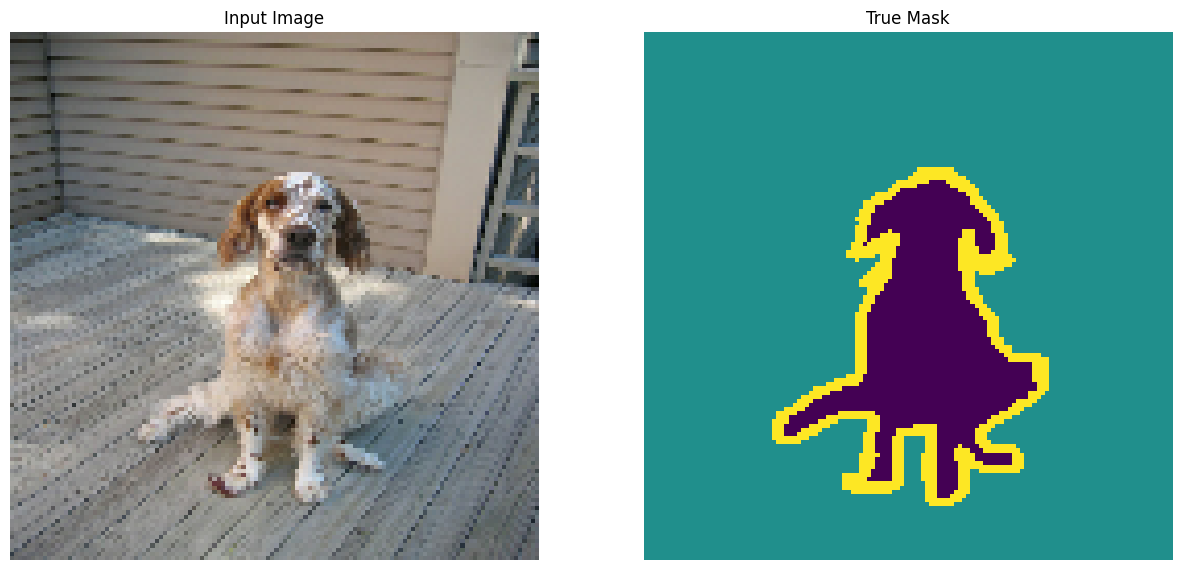

2023-05-29 23:42:42.200288: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


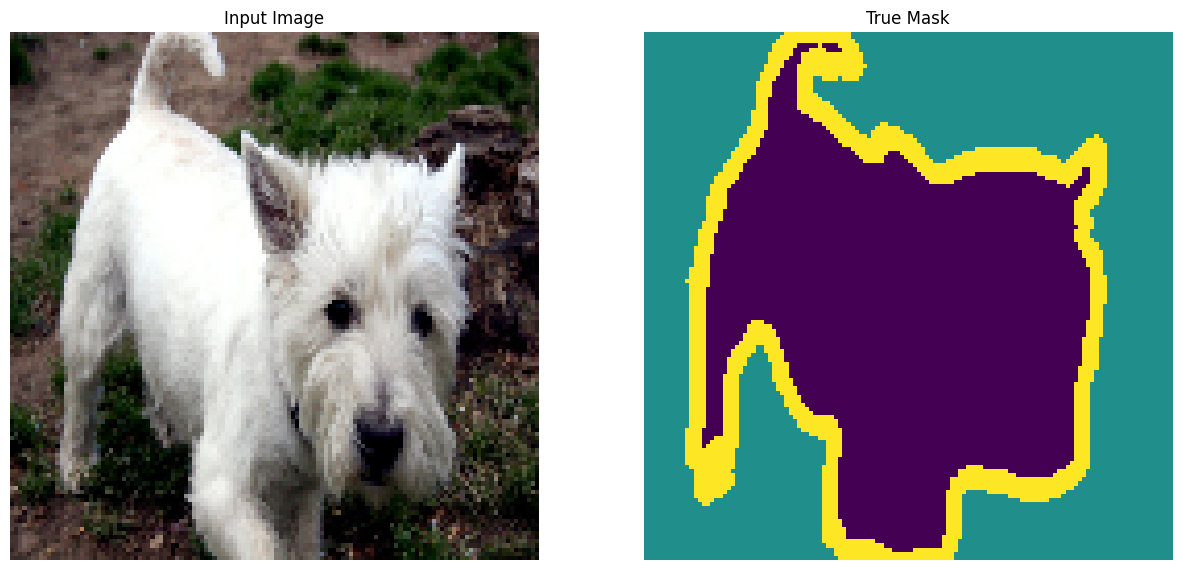

In [9]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])


In [10]:
def get_model(img_size, num_classes):
    inputs = tf.keras.layers.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = tf.keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
tf.keras.backend.clear_session()

# Build model
model = get_model((128, 128), 3)
model.summary()


model.compile(
    optimizer=optimizers.RMSprop(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=metrics.SparseCategoricalAccuracy(),
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [14]:
print(tf.keras.utils.plot_model(model, to_file="lab11.png", show_shapes=True))

<IPython.core.display.Image object>


In [16]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display(
            [
                sample_image,
                sample_mask,
                create_mask(model.predict(sample_image[tf.newaxis, ...])),
            ]
        )

1/1 [==============================] - 1s 576ms/step


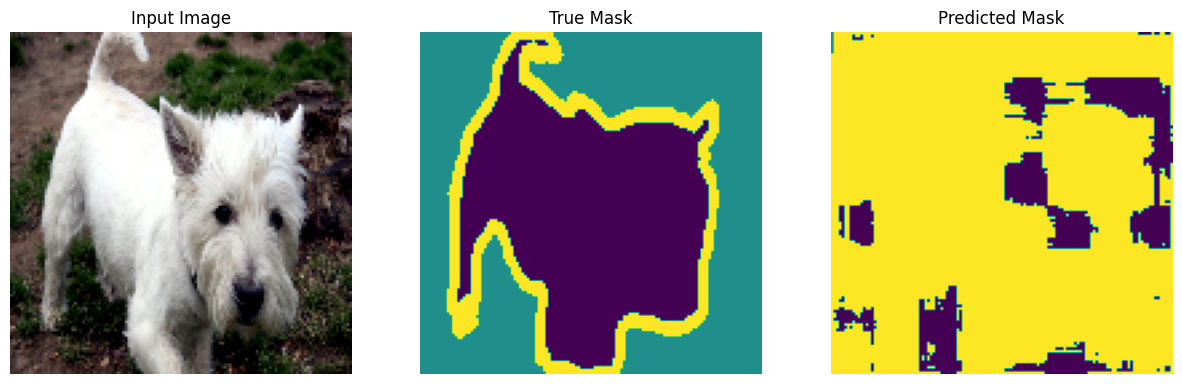

In [17]:
show_predictions()

In [18]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print("\nSample Prediction after epoch {}\n".format(epoch + 1))

1/1 [==============================] - 0s 10ms/step


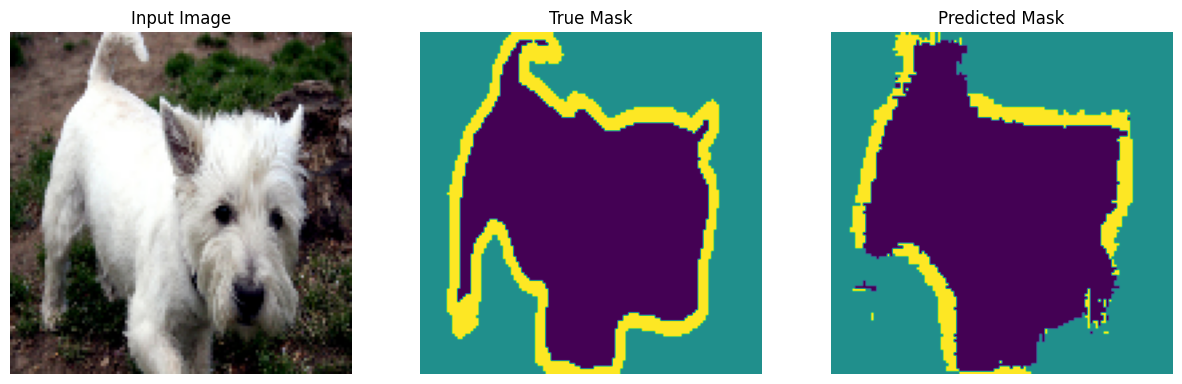


Sample Prediction after epoch 20

115/115 [==============================] - 4s 36ms/step - loss: 0.3532 - sparse_categorical_accuracy: 0.8577


In [19]:
model_history = model.fit(
    train_batches,
    epochs=20,
    steps_per_epoch=info.splits["train"].num_examples // 32,
    validation_steps=info.splits["test"].num_examples // 32,
    validation_data=valid_batches,
    callbacks=[DisplayCallback()],
)

In [20]:
model.evaluate(test_batches, verbose=1)

81/81 [==============================] - 1s 11ms/step - loss: 0.4785 - sparse_categorical_accuracy: 0.8168


[0.47845420241355896, 0.8168323636054993]